In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import json
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from statsmodels.stats.multitest import fdrcorrection

In [26]:
feature_names = json.loads(open('utils/lut_dict.txt').read())

In [27]:
for feature in feature_names.keys():
    if 'area' in feature:
        feature_names[feature] = feature_names[feature] + " A"
    elif 'thickness' in feature:
        feature_names[feature] = feature_names[feature] + " T"
    else:
        feature_names[feature] = feature_names[feature]  

In [28]:
# HISTOGRAM
#############################################################

# create dataframes
important_features = pd.read_csv("out/important_features.csv")
ml_dataframe = pd.read_csv("stats/ml_dataframe.csv")

# rename columns 
important_features = important_features.rename(columns={'feature': 'importance'})
important_features = important_features.rename(columns={'Unnamed: 0': 'feature'})

# print all important features into a new list
important_features_list = important_features['feature'].tolist()

# save names of features where importance >=5 to a list called top_features
top_features = important_features[important_features['importance'] >= 5]
top_features = top_features['feature'].tolist()

# make separate dataframe for top features' importance 
top_features_importance = important_features[important_features['importance'] >= 5]

# reading LUT
region_names = np.array(list([feature_names[feature] for feature in important_features['feature']]))

# add label column
important_features['feature type'] = np.where(important_features['feature'].str.contains('thickness'), "thickness", 
                                       np.where(important_features['feature'].str.contains('area'), "area", "volume"))
important_features['feature'] = region_names

In [29]:
# generate histogram
with plt.xkcd():
    ax1 = sns.catplot(data=important_features, kind="bar", x="importance", y="feature", height=15, aspect=2, hue="feature type", dodge=False, palette=['#5Ef2A8', '#6E8CE3', '#FF9F21'])
    plt.xticks([0,1,2,3,4,5,6,7,8,9,10])    
    plt.title("Feature Importance", fontsize=40)
    plt.xlabel("Importance", fontsize=30)
    plt.ylabel("Feature", fontsize=30)
    plt.savefig('out/important_features.png', dpi=300, bbox_inches='tight')
    plt.clf()

/home/apps/anaconda3/lib/python3.8/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  warnings.warn(
/home/apps/anaconda3/lib/python3.8/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  warnings.warn(


<Figure size 3161.88x1500 with 0 Axes>

In [30]:
# FEATURE WEIGHTS
#############################################################

# make a graph to visualize the feature weights data in outs folder ([fold]_feature_weights.csv)
#load df from all folds and merge into one dataframe

#create new dataframe for each fold file

dataframes = []  # List to store the dataframes

for i in range(0,10):
    filename=('out/{}_feature_weights.csv'.format(i))
     # Generate the filename
    df = pd.read_csv(filename)  # Read the CSV file into a dataframe
    dataframes.append(df)

# rename first column of each dataframe to fold #
for i in range(0,10):
    dataframes[i] = dataframes[i].rename(columns={'Unnamed: 0': 'fold #'})
    dataframes[i]['fold #'] = i

# merge all 10 dataframes within dataframes list into a single dataframe
all_weights = pd.concat(dataframes)
all_weights.head()

,fold #,rh_G_temp_sup-G_T_transv_area,lh_S_circular_insula_inf_thickness,rh_S_circular_insula_inf_thickness,rh_S_front_sup_area,lh_G_rectus_thickness,rh_VM,rh_PuM,lh_S_pericallosal_area,lh_PuI,...,lh_G_temp_sup-Lateral_area,rh_G_cuneus_area,rh_S_temporal_sup_area,lh_G_front_inf-Orbital_area,rh_MGN,lh_AV,rh_Pole_temporal_area,rh_S_orbital-H_Shaped_area,lh_S_collat_transv_post_area,lh_HATA
0,0,-0.071184,-0.072614,-0.108120,0.100331,0.204653,-0.491208,-0.156778,0.108842,0.139625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1,NaN,NaN,NaN,NaN,NaN,-0.388743,NaN,0.187188,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2,-0.053031,-0.054735,-0.091603,0.133508,0.150992,-0.350524,NaN,0.132780,0.122341,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3,NaN,-0.079293,NaN,0.062400,NaN,-0.413438,-0.147736,0.174252,0.115615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,4,NaN,-0.066225,-0.074286,0.132953,0.210409,-0.416574,NaN,0.228738,0.135578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# melt
all_weights = pd.melt(all_weights, id_vars=['fold #'], var_name='feature', value_name='weight')
print(all_weights)

     fold #                        feature    weight
0         0  rh_G_temp_sup-G_T_transv_area -0.071184
1         1  rh_G_temp_sup-G_T_transv_area       NaN
2         2  rh_G_temp_sup-G_T_transv_area -0.053031
3         3  rh_G_temp_sup-G_T_transv_area       NaN
4         4  rh_G_temp_sup-G_T_transv_area       NaN
..      ...                            ...       ...
615       5                        lh_HATA       NaN
616       6                        lh_HATA       NaN
617       7                        lh_HATA       NaN
618       8                        lh_HATA       NaN
619       9                        lh_HATA -0.084661

[620 rows x 3 columns]


In [32]:
print(important_features)

           feature  importance feature type
0           R VM V          10       volume
1       L PerCaS A           9         area
2        R PosCG A           8         area
3        R SupFS A           8         area
4           L RG T           7    thickness
..             ...         ...          ...
57       L PosLS A           1         area
58         L PuL V           1       volume
59    R CA3 Head V           1       volume
60  L Whole Hipp V           1       volume
61        L HATA V           1       volume

[62 rows x 3 columns]


In [34]:
# make top_weights dataframe where feature is in top_features list
top_weights = all_weights[all_weights['feature'].isin(top_features)]

# abbreviate names
region_names = np.array(list([feature_names[feature] for feature in top_weights['feature']]))
top_weights['feature'] = region_names

#do same for top_features_importance
region_names = np.array(list([feature_names[feature] for feature in top_features_importance['feature']]))
top_features_importance['feature'] = region_names

# add 'importance' column to top_weights datafram where the importance is the importance of that feature based on 'importance' from top_features_importance
top_weights['importance'] = top_weights['feature'].map(top_features_importance.set_index('feature')['importance'])


# abs value
top_weights['weight'] = top_weights['weight'].abs()

/tmp/ipykernel_633579/3925176343.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_weights['feature'] = region_names
/tmp/ipykernel_633579/3925176343.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_importance['feature'] = region_names
/tmp/ipykernel_633579/3925176343.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [35]:
print(top_features_importance)

                feature  importance
0                R VM V          10
1            L PerCaS A           9
2             R PosCG A           8
3             R SupFS A           8
4                L RG T           7
5   R L-Sg V (Limitans)           7
6               L TOS A           7
7                R HG A           6
8          L InfCrInS T           6
9               L PuI V           6
10         R CA3 Body V           6
11              L VPL V           6
12              R FuG A           6
13              R MDm V           5
14           L PerCaS T           5
15         R InfCrInS T           5
16              R Cun T           5


In [36]:
# boxplot of the dataframe where y=weight and x=feature

fig = plt.figure(figsize=(11, 5))
with plt.xkcd():
    ax = sns.boxplot(data=top_weights, x="feature", y="weight",orient="v", palette="pastel", order=top_weights.groupby('feature').mean()
                .sort_values('weight', ascending=False).index, showmeans=True, meanprops={"marker":"o","markerfacecolor":"white", 
                                                                                            "markersize":"20", "markeredgecolor":"gray", "markeredgewidth":"2"})
    # x-axis labels 
    xlabels = top_weights.groupby('feature').mean().sort_values('weight', ascending=False).index.tolist()
    top_features_importance = top_features_importance.set_index('feature').loc[xlabels].reset_index()
    
    # store means of boxplot in a list
    means = []
    for i, _ in  enumerate(top_features):
        means.append((top_weights.groupby('feature').mean().sort_values('weight', ascending=False)['weight'][i]))

    plt.xlabel('Feature')
    plt.ylabel('Weight (abs. value)')
    plt.title('Top Feature Weights', size=20)
    plt.xticks(rotation=30)
    sns.stripplot(data=top_weights, x="feature", y="weight", color="gray", zorder=1, size=4, jitter=0.2, order=top_weights.groupby('feature')
                .mean().sort_values('weight', ascending=False).index)

    # add text labels corresponding to top_features_importance at each of the means
    for i,_ in enumerate(top_features):
        plt.text(x=i, y=(means[i]-0.005), s=top_features_importance['importance'][i], color='gray', ha="center", fontsize=12)

    plt.savefig('out/feature_weights.png', dpi=300, bbox_inches='tight')
    plt.clf()

/home/apps/anaconda3/lib/python3.8/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  warnings.warn(


<Figure size 1100x500 with 0 Axes>

In [37]:
# T-TEST
#############################################################

# create dataframe with only top features
top_features_dataframe = ml_dataframe[top_features]
top_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']

# calculate mean for each column and put in list
means = []
for i, _ in enumerate(top_features):
    means.append(top_features_dataframe.mean()[top_features[i]])

# melt and organize dataframe for top features
top_features_dataframe = top_features_dataframe.melt(id_vars=['diagnosis'], var_name='feature', value_name='value').fillna(0)
top_features_dataframe['feature'] = [feature_names[feature] for feature in top_features_dataframe['feature']]

# # create and melt dataframe for all important features
# important_features_dataframe = ml_dataframe[important_features_list]
# important_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']
# important_features_dataframe = important_features_dataframe.melt(id_vars=['diagnosis'], var_name='feature', value_name='value').fillna(0)
# important_features_dataframe['feature'] = [feature_names[feature] for feature in important_features_dataframe['feature']]

# set up groups for t-test
ms_dataframe = ml_dataframe[ml_dataframe['diagnosis'] == 'MS']
ms_tn_dataframe = ml_dataframe[ml_dataframe['diagnosis'] == 'MS-TN']

/tmp/ipykernel_633579/296247506.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_dataframe['diagnosis'] = ml_dataframe['diagnosis']
/tmp/ipykernel_633579/296247506.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  means.append(top_features_dataframe.mean()[top_features[i]])


In [ ]:
# # run t-test

# p_vals = []
# p_corrected = []
# stats_vals = []

# # running t-test on top features
# for feature in top_features:
#     input_ms = ms_dataframe[feature]
#     input_ms_tn = ms_tn_dataframe[feature]
#     ttest1 = stats.ttest_ind(input_ms, input_ms_tn, equal_var=True, nan_policy="omit", permutations=None, random_state=None, alternative="two-sided", trim=0)
#     #nan_policy='propagate' when all data there
#     p_vals.append(ttest1.pvalue)
#     stats_vals.append(ttest1.statistic)

In [ ]:
    # # running t-test on all important features
# for feature in important_features_list:
#     input_ms = ms_dataframe[feature]
#     input_ms_tn = ms_tn_dataframe[feature]
#     ttest1 = stats.ttest_ind(input_ms, input_ms_tn, equal_var=True, nan_policy="omit", permutations=None, random_state=None, alternative="two-sided", trim=0)
#     p_vals.append(ttest1.pvalue)
#     stats_vals.append(ttest1.statistic)

In [ ]:
# # correct p-values for multiple tests

# rejected_pval, p_corrected = fdrcorrection(p_vals, alpha=0.05, method='indep')

# # replace rejected p-values with "NS"
# for i in range(len(p_corrected)):
#     if rejected_pval[i] == False:
#         p_corrected[i] = 1
#     else:
#         p_corrected[i] = p_corrected[i]

# # save p_corrected of top_features to a csv
# p_corrected_df = pd.DataFrame(p_corrected, columns=['p_corrected'])
# p_corrected_df['feature'] = top_features


# # if saving all important features
# # p_corrected_df['feature'] = important_features_list
# # significant_pvals_dict = {}
# # for pval in p_corrected_df['p_corrected']:
# #     if pval != 1:
# #         # add feature name and pval to dictionary
# #         significant_pvals_dict[p_corrected_df['feature'][p_corrected_df['p_corrected'] == pval].values[0]] = pval
# #         # sort by descending
# # significant_pvals_dict = dict(sorted(significant_pvals_dict.items(), key=lambda item: item[1], reverse=False))

# # print(significant_pvals_dict)
# # p_corrected_df.to_csv('out/p_corrected_all_significant.csv')


# # save p_corrected of top features to a csv
# p_corrected_df.to_csv('out/p_corrected.csv')

# # copy df into new one  
# p_corrected_df_values = p_corrected_df.copy()

# p_corrected_df['p_corrected'] = ['NS' if p_corrected == 1 else '*' if p_corrected > 0.01 
#                                  else '**' if p_corrected > 0.001 else '***' for p_corrected in p_corrected_df['p_corrected']]
# p_values_codes = p_corrected_df['p_corrected'].tolist()

In [77]:
# plotting the values of the top predictors

with plt.xkcd():
    sns.catplot(data=top_features_dataframe, kind="box", x="feature", y="value", hue="diagnosis", height=8, aspect=2, palette="pastel")        
    plt.xticks(rotation=30)
    # add text labels corresponding to top_features_importance at each of the means
    # for i,_ in enumerate(top_features):
    #     plt.text(x=i, y=(means[i]), s=p_values_codes[i], color='gray', ha="center", fontsize=12)
    plt.yscale('log')
    plt.xlabel('Feature')
    plt.ylabel('Size')
    plt.title('Top Features', size=20)
    # plt.savefig('out/top_feature_values.png', dpi=300, bbox_inches='tight')
    plt.clf()

/home/apps/anaconda3/lib/python3.8/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  warnings.warn(
/home/apps/anaconda3/lib/python3.8/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  warnings.warn(


<Figure size 1732.73x800 with 0 Axes>

In [40]:
# make separate dataframes depending on region
top_features_dataframe_hippo = top_features_dataframe[top_features_dataframe['feature'].str.contains('CA1|CA2|CA3|CA4|DG|SUB|ERC|Fimbria')]
top_features_dataframe_thal = top_features_dataframe[top_features_dataframe['feature'].str.contains('VPL|PuI|VM|VPL|VPM|PuM|VA|VL|PuL|MDm|L-Sg')]
top_features_dataframe_t = top_features_dataframe[top_features_dataframe['feature'].str.endswith('T')]
top_features_dataframe_a = top_features_dataframe[top_features_dataframe['feature'].str.endswith('A')]

# print unique values of top features thal and hippo
print(top_features_dataframe_thal['feature'].unique())
print(top_features_dataframe_t['feature'].unique())
print(top_features_dataframe['feature'].unique())

['R VM V' 'R L-Sg V (Limitans)' 'L PuI V' 'L VPL V' 'R MDm V']
['L RG T' 'L InfCrInS T' 'L PerCaS T' 'R InfCrInS T' 'R Cun T']
['R VM V' 'L PerCaS A' 'R PosCG A' 'R SupFS A' 'L RG T'
 'R L-Sg V (Limitans)' 'L TOS A' 'R HG A' 'L InfCrInS T' 'L PuI V'
 'R CA3 Body V' 'L VPL V' 'R FuG A' 'R MDm V' 'L PerCaS T' 'R InfCrInS T'
 'R Cun T']


In [49]:
# do different subplots for top features separated from the different regions

with plt.xkcd():
    plt.figure(figsize=(30, 20))
    plt.suptitle('Univariate Statistics', size=40)
    plt.subplots_adjust(hspace=0.2)

    ax1 = plt.subplot(2,3,(1,3))
    ax2 = plt.subplot(2,3,4)
    ax3 = plt.subplot(2,3,5)
    ax4 = plt.subplot(2,3,6)

    sns.boxplot(ax=ax1, data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette="pastel")
    sns.boxplot(ax=ax2, data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette="pastel")
    sns.boxplot(ax=ax3, data=top_features_dataframe_thal, x="feature", y="value", hue="diagnosis", palette="pastel")
    sns.boxplot(ax=ax4, data=top_features_dataframe_hippo, x="feature", y="value", hue="diagnosis", palette="pastel")
    
   
    ax1.set_ylabel('Size')
    ax2.set_ylabel('Size')
    ax3.set_ylabel('Size')
    ax4.set_ylabel('Size')

    plt.setp(ax1.get_xticklabels(), rotation=30)
    plt.setp(ax2.get_xticklabels(), rotation=30)
    plt.setp(ax3.get_xticklabels(), rotation=30)
    plt.setp(ax4.get_xticklabels(), rotation=30)

    ax1.set_title('Cortical Area', size=20)
    ax2.set_title('Cortical Thickness', size=20)
    ax3.set_title('Thalamic Volume', size=20)
    ax4.set_title('Hippocampal Volume', size=20)

    #add scatterplot on top of boxplot
    sns.stripplot(ax=ax1, data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette="pastel",
                    dodge=True, size=5, edgecolor="white", linewidth=1)
    sns.stripplot(ax=ax2, data=top_features_dataframe_t, x="feature", y="value", hue="diagnosis", palette="pastel", 
                  dodge=True, size=5, edgecolor="white", linewidth=1)   
    sns.stripplot(ax=ax3, data=top_features_dataframe_thal, x="feature", y="value", hue="diagnosis", palette="pastel",
                    dodge=True, size=5, edgecolor="white", linewidth=1)
    sns.stripplot(ax=ax4, data=top_features_dataframe_hippo, x="feature", y="value", hue="diagnosis", palette="pastel",
                    dodge=True, size=5, edgecolor="white", linewidth=1)
    
    ax1.set_xlabel(" ")
    ax2.set_xlabel(" ")
    ax4.set_xlabel(" ")
    plt.show()
    # plt.savefig('out/univariate_statistics.png', dpi=300, bbox_inches='tight')

/home/apps/anaconda3/lib/python3.8/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  warnings.warn(


ValueError: 'vertices' must be a 2D list or array with shape Nx2

<Figure size 3000x2000 with 4 Axes>

/home/apps/anaconda3/lib/python3.8/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  warnings.warn(


<Figure size 640x480 with 0 Axes>

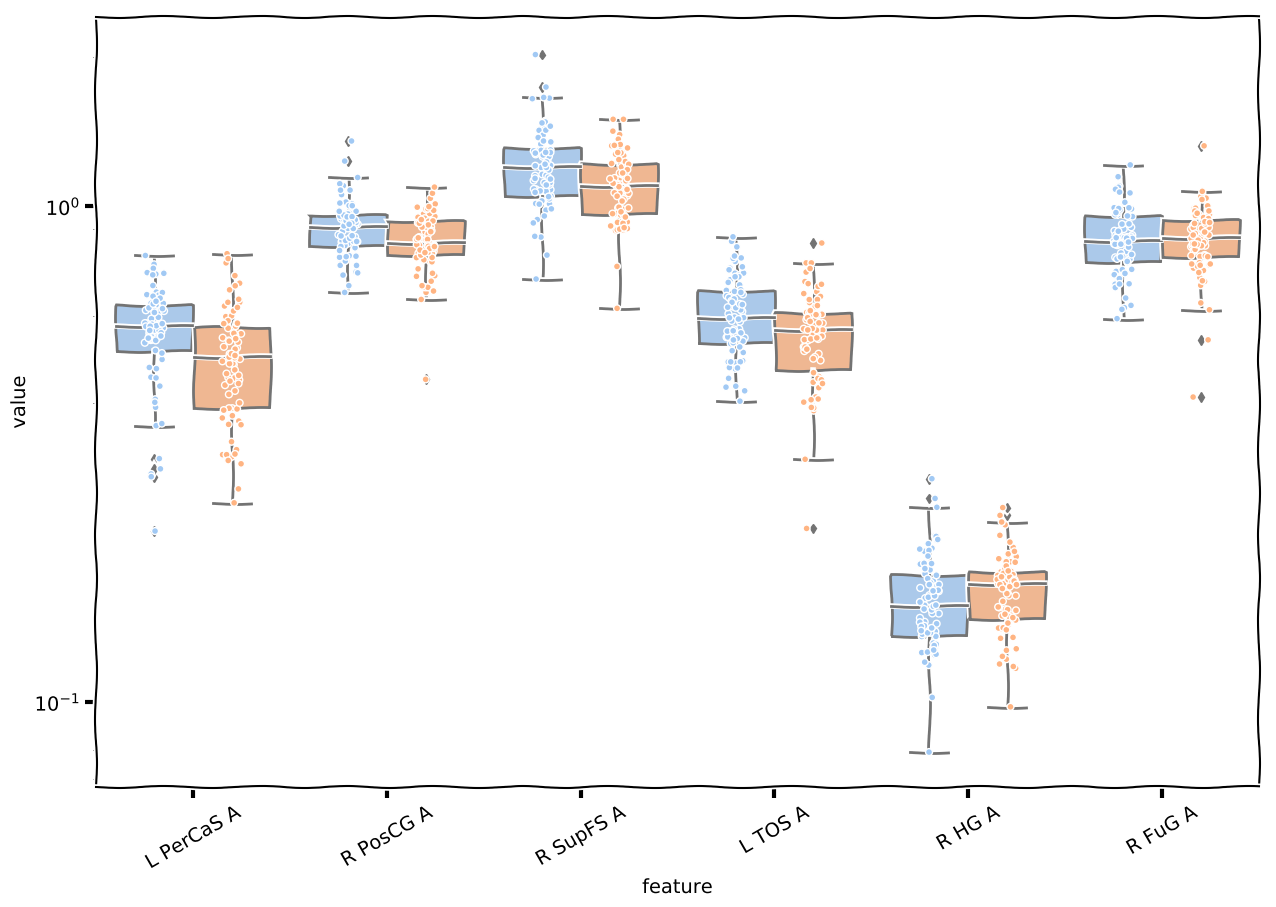

In [76]:
with plt.xkcd():
    plt.suptitle('Univariate Statistics: Cortical Area', size=20)
    plt.figure(figsize=(15, 10))
    ax=sns.boxplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette="pastel")
    plt.setp(ax.get_xticklabels(), rotation=30)
    ax.set_yscale("log")
    #add scatterplot on top of boxplot
    ax1=sns.stripplot(data=top_features_dataframe_a, x="feature", y="value", hue="diagnosis", palette="pastel",
                    dodge=True, size=5, edgecolor="white", linewidth=1)
    ax1.get_legend().remove()
    plt.savefig("out/cortical_area.png", dpi=300, bbox_inches='tight')

In [ ]:
# plotting the values of all the important features


# with plt.xkcd():
#     sns.catplot(data=important_features_dataframe, kind="box", x="feature", y="value", hue="diagnosis", height=10, aspect=10, palette="pastel")        
#     plt.xticks(rotation=30)
#     plt.yscale('log')
#     plt.xlabel('Feature')
#     plt.ylabel('Size')
#     plt.title('Top Features', size=20)
#     plt.savefig('out/important_feature_values.png', dpi=300, bbox_inches='tight')
#     plt.show()
#     plt.clf()

In [ ]:
# run stats on ms_studies demographic data

ms_studies = pd.read_csv('stats/MS_studies.csv')
ms_studies = ms_studies.dropna()
# make two dataframes based on ms or ms-tn diagnosis
ms_studies_ms = ms_studies[ms_studies['diagnosis'] == 'MS']
ms_studies_mstn = ms_studies[ms_studies['diagnosis'] == 'MS-TN']

# calculate mean and standard deviation of age and duration of ms from ms and mstn dataframes and print,also sexes
print('MS sex:\n{}'.format(ms_studies_ms['sex'].value_counts()))
print("MS mean age: {} std: {}".format(ms_studies_ms['age'].mean(), ms_studies_ms['age'].std()))
print("MS mean MS duration: {} std: {}\n".format(ms_studies_ms['duration_of_ms'].mean(), ms_studies_ms['duration_of_ms'].std()))
print('MS-TN sex:\n{}'.format(ms_studies_mstn['sex'].value_counts()))
print("MS-TN mean age: {} std: {}".format(ms_studies_mstn['age'].mean(), ms_studies_mstn['age'].std()))
print("MS-TN mean MS duration: {} std: {}".format(ms_studies_mstn['duration_of_ms'].mean(), ms_studies_mstn['duration_of_ms'].std()))
print("MS-TN mean pain duration: {} std: {}".format(ms_studies_mstn['duration_of_pain'].mean(), ms_studies_mstn['duration_of_pain'].std()))